In [1]:
!pip install -q kagglehub

In [67]:
import os

os.environ["KAGGLE_API_TOKEN"] = "KGAT_a67f093a25aa7c42c660e3dbb2aa9961"

In [68]:
import kagglehub
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

target_path = os.path.join(os.getcwd(), "intel_dataset")
!mkdir -p {target_path}
!cp -r {dataset_path}/* {target_path}/

print("Dataset ready at:", target_path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset ready at: /content/intel_dataset


In [69]:
import os
import glob
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [70]:
TRAIN_FOLDER_PATH = '/content/intel_dataset/seg_train/seg_train'
TEST_FOLDER_PATH = '/content/intel_dataset/seg_test/seg_test'
PRED_FOLDER_PATH = '/content/intel_dataset/seg_pred/seg_pred'


In [71]:
def dir_counts(dir_path, pred=False):
  if pred:
    files = glob.glob(pathname=str(dir_path +'/*.jpg'))
    print(f'For training data , found {len(files)}')
    return
  for folder in os.listdir(dir_path):
      images = glob.glob(pathname=str(dir_path +'/'+folder+'/*.jpg'))
      print(f'For training data , found {len(images)} in folder {folder}')

In [72]:
dir_counts(TRAIN_FOLDER_PATH)

For training data , found 2512 in folder mountain
For training data , found 2271 in folder forest
For training data , found 2382 in folder street
For training data , found 2191 in folder buildings
For training data , found 2274 in folder sea
For training data , found 2404 in folder glacier


In [73]:
dir_counts(TEST_FOLDER_PATH)

For training data , found 525 in folder mountain
For training data , found 474 in folder forest
For training data , found 501 in folder street
For training data , found 437 in folder buildings
For training data , found 510 in folder sea
For training data , found 553 in folder glacier


In [74]:
dir_counts(PRED_FOLDER_PATH, pred=True)

For training data , found 7301


In [75]:
def image_sizes(dir_path, pred=False):
  sizes = []
  if pred:
      images = glob.glob(pathname=str(dir_path + '/*.jpg'))
      for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)
  for folder in os.listdir(dir_path):

    images = glob.glob(pathname=str(dir_path + '/' + folder + '/*.jpg'))
    for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)

  print(pd.Series(sizes).value_counts().head())

In [76]:
image_sizes(TRAIN_FOLDER_PATH)


(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
Name: count, dtype: int64


In [77]:
image_sizes(TEST_FOLDER_PATH)

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(72, 150, 3)        1
Name: count, dtype: int64


In [78]:
image_sizes(PRED_FOLDER_PATH, True)

(150, 150, 3)    7288
(144, 150, 3)       1
(143, 150, 3)       1
(126, 150, 3)       1
(149, 150, 3)       1
Name: count, dtype: int64


array([[[131, 194, 247],
        [131, 194, 247],
        [131, 194, 245],
        ...,
        [162, 217, 237],
        [165, 217, 238],
        [166, 218, 239]],

       [[131, 194, 247],
        [131, 194, 245],
        [131, 194, 245],
        ...,
        [166, 218, 239],
        [168, 219, 240],
        [166, 217, 238]],

       [[130, 193, 244],
        [130, 193, 244],
        [131, 193, 244],
        ...,
        [170, 218, 240],
        [171, 219, 239],
        [170, 218, 238]],

       ...,

       [[171, 171, 163],
        [168, 168, 158],
        [165, 165, 157],
        ...,
        [125, 147,  46],
        [119, 144,  43],
        [122, 147,  46]],

       [[190, 187, 178],
        [201, 199, 187],
        [216, 213, 204],
        ...,
        [134, 156,  56],
        [130, 154,  56],
        [136, 160,  62]],

       [[253, 251, 239],
        [249, 247, 235],
        [245, 243, 231],
        ...,
        [133, 155,  57],
        [125, 149,  53],
        [129, 153,  57]]], dtype=uint8)
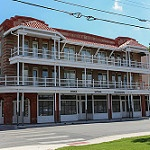

In [79]:
plt.imread("/content/intel_dataset/seg_train/seg_train/buildings/1001.jpg")


In [80]:
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # ~1/255 scaling equivalent
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [81]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER_PATH, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_FOLDER_PATH, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [82]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*12*12, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = CustomCNN().to(device)

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [84]:
def train_model(model, epochs=10):
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Train {train_acc:.3f} | Val {val_acc:.3f}")

    return history

history = train_model(model)

100%|██████████| 439/439 [00:28<00:00, 15.65it/s]


Epoch 1: Train 0.618 | Val 0.755


100%|██████████| 439/439 [00:28<00:00, 15.48it/s]


Epoch 2: Train 0.733 | Val 0.801


100%|██████████| 439/439 [00:30<00:00, 14.59it/s]


Epoch 3: Train 0.770 | Val 0.801


100%|██████████| 439/439 [00:31<00:00, 14.11it/s]


Epoch 4: Train 0.788 | Val 0.841


100%|██████████| 439/439 [00:30<00:00, 14.19it/s]


Epoch 5: Train 0.804 | Val 0.830


100%|██████████| 439/439 [00:31<00:00, 13.94it/s]


Epoch 6: Train 0.815 | Val 0.852


100%|██████████| 439/439 [00:30<00:00, 14.45it/s]


Epoch 7: Train 0.820 | Val 0.860


100%|██████████| 439/439 [00:30<00:00, 14.45it/s]


Epoch 8: Train 0.833 | Val 0.802


100%|██████████| 439/439 [00:30<00:00, 14.42it/s]


Epoch 9: Train 0.841 | Val 0.834


100%|██████████| 439/439 [00:30<00:00, 14.48it/s]


Epoch 10: Train 0.848 | Val 0.859


In [85]:
ASSETS_FOLDER_PATH = "assets"
os.makedirs(ASSETS_FOLDER_PATH, exist_ok=True)

torch.save(model.state_dict(), f"{ASSETS_FOLDER_PATH}/intel-scratch.pt")

idx2label = {v: k for k, v in train_dataset.class_to_idx.items()}
joblib.dump(idx2label, f"{ASSETS_FOLDER_PATH}/idx2label.joblib")

print("Saved assets!")

Saved assets!


In [86]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 6)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 148MB/s]


In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [88]:
history = train_model(model, epochs=10)

100%|██████████| 439/439 [00:18<00:00, 23.34it/s]


Epoch 1: Train 0.699 | Val 0.845


100%|██████████| 439/439 [00:16<00:00, 26.79it/s]


Epoch 2: Train 0.808 | Val 0.852


100%|██████████| 439/439 [00:17<00:00, 24.91it/s]


Epoch 3: Train 0.825 | Val 0.861


100%|██████████| 439/439 [00:16<00:00, 26.64it/s]


Epoch 4: Train 0.839 | Val 0.861


100%|██████████| 439/439 [00:16<00:00, 26.16it/s]


Epoch 5: Train 0.842 | Val 0.861


100%|██████████| 439/439 [00:16<00:00, 26.51it/s]


Epoch 6: Train 0.845 | Val 0.863


100%|██████████| 439/439 [00:16<00:00, 26.55it/s]


Epoch 7: Train 0.853 | Val 0.866


100%|██████████| 439/439 [00:17<00:00, 25.16it/s]


Epoch 8: Train 0.854 | Val 0.869


100%|██████████| 439/439 [00:16<00:00, 26.25it/s]


Epoch 9: Train 0.854 | Val 0.872


100%|██████████| 439/439 [00:16<00:00, 26.25it/s]


Epoch 10: Train 0.857 | Val 0.869


In [89]:
ASSETS_FOLDER_PATH = "assets"
os.makedirs(ASSETS_FOLDER_PATH, exist_ok=True)

torch.save(model.state_dict(), f"{ASSETS_FOLDER_PATH}/intel-mobilenet.pt")

idx2label = {v: k for k, v in train_dataset.class_to_idx.items()}
joblib.dump(idx2label, f"{ASSETS_FOLDER_PATH}/idx2label.joblib")

print("Saved assets!")

Saved assets!
